In [1]:
import os 
import numpy as np
import pandas as pd
import nltk

C:\Users\Mido\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)
C:\Users\Mido\Anaconda3\lib\site-packages\sklearn\feature_extraction\image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
C:\Users\Mido\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `floa

# Data Retrieval

In [2]:
import urllib.request

url = 'https://cs.nyu.edu/~roweis/data/nips12raw_str602.tgz'
filename = 'nips12raw_str602'
urllib.request.urlretrieve(url, filename)

('nips12raw_str602', <http.client.HTTPMessage at 0x252a6be0eb8>)

In [3]:
!tar -xzf nips12raw_str602

In [4]:
DATA_PATH = 'nipstxt/'
print(os.listdir(DATA_PATH))

['idx', 'MATLAB_NOTES', 'nips00', 'nips01', 'nips02', 'nips03', 'nips04', 'nips05', 'nips06', 'nips07', 'nips08', 'nips09', 'nips10', 'nips11', 'nips12', 'orig', 'RAW_DATA_NOTES', 'README_yann']


# Load and View Dataset

In [5]:
folders = ['nips{0:02}'.format(i) for i in range(0, 13)]
# Read all texts into a list
papers = []
for folder in folders:
    file_names = os.listdir(DATA_PATH + folder)
    for file_name in file_names:
        with open(DATA_PATH + folder + '/' + file_name, encoding='utf-8', errors='ignore', mode='r+') as f:#seperate 'em with /
            data = f.read()
        papers.append(data)
len(papers)        

1740

 However, it looks like the OCR hasn’t worked perfectly and we have
some missing characters here and there. This is expected, but also makes this task more
challenging!

In [6]:
print(papers[0][:1000])

1 
CONNECTIVITY VERSUS ENTROPY 
Yaser S. Abu-Mostafa 
California Institute of Technology 
Pasadena, CA 91125 
ABSTRACT 
How does the connectivity of a neural network (number of synapses per 
neuron) relate to the complexity of the problems it can handle (measured by 
the entropy)? Switching theory would suggest no relation at all, since all Boolean 
functions can be implemented using a circuit with very low connectivity (e.g., 
using two-input NAND gates). However, for a network that learns a problem 
from examples using a local learning rule, we prove that the entropy of the 
problem becomes a lower bound for the connectivity of the network. 
INTRODUCTION 
The most distinguishing feature of neural networks is their ability to spon- 
taneously learn the desired function from 'training' samples, i.e., their ability 
to program themselves. Clearly, a given neural network cannot just learn any 
function, there must be some restrictions on which networks can learn which 
functions. One obv

# Basic Text Wrangling

In [7]:
stop_words = nltk.corpus.stopwords.words('english')
wtk = nltk.tokenize.RegexpTokenizer(r'\w+')#any word
wnl = nltk.stem.wordnet.WordNetLemmatizer()

def normalize_corpus(papers):
    norm_papers = []
    for paper in papers:
        paper = paper.lower()
        paper_tokens = [token.strip() for token in wtk.tokenize(paper)]# word tokenization
        paper_tokens = [wnl.lemmatize(token) for token in paper_tokens if not token.isnumeric()]
        paper_tokens = [token for token in paper_tokens if len(token) > 1]
        paper_tokens = [token for token in paper_tokens if token not in stop_words]
        paper_tokens = list(filter(None, paper_tokens))
        if paper_tokens:
            norm_papers.append(paper_tokens)
            
    return norm_papers

In [8]:
norm_papers = normalize_corpus(papers)
print(len(norm_papers))

1740


In [9]:
# Viewing a processed paper
print(norm_papers[0][:50])

['connectivity', 'versus', 'entropy', 'yaser', 'abu', 'mostafa', 'california', 'institute', 'technology', 'pasadena', 'ca', 'abstract', 'doe', 'connectivity', 'neural', 'network', 'number', 'synapsis', 'per', 'neuron', 'relate', 'complexity', 'problem', 'handle', 'measured', 'entropy', 'switching', 'theory', 'would', 'suggest', 'relation', 'since', 'boolean', 'function', 'implemented', 'using', 'circuit', 'low', 'connectivity', 'using', 'two', 'input', 'nand', 'gate', 'however', 'network', 'learns', 'problem', 'example', 'using']


We are now ready to start building topic models

Without further ado, let’s get started by looking at ways to generate phrases with
influential bi-grams and remove some terms that may not be useful before feature
engineering.

# Text Representation with Featuer Engineering

Before feature engineering and vectorization, we want to extract some useful bi-gram
based phrases from our research papers and remove some unnecessary terms

In [10]:
import gensim

bigram = gensim.models.Phrases(norm_papers, min_count=20, threshold=20, delimiter=b'_') # higher threshold fewer phrases.
bigram_model = gensim.models.phrases.Phraser(bigram)

print(bigram_model[norm_papers[0]][:50])

['connectivity', 'versus', 'entropy', 'yaser', 'abu_mostafa', 'california_institute', 'technology_pasadena', 'ca_abstract', 'doe', 'connectivity', 'neural_network', 'number', 'synapsis', 'per', 'neuron', 'relate', 'complexity', 'problem', 'handle', 'measured', 'entropy', 'switching', 'theory', 'would', 'suggest', 'relation', 'since', 'boolean_function', 'implemented', 'using', 'circuit', 'low', 'connectivity', 'using', 'two', 'input', 'nand', 'gate', 'however', 'network', 'learns', 'problem', 'example', 'using', 'local', 'learning', 'rule', 'prove', 'entropy', 'problem']


Let’s generate phrases for all our tokenized research papers and build a vocabulary
that will help us obtain a unique term/phrase to number mapping

In [11]:
norm_corpus_bigrams = [bigram_model[doc] for doc in norm_papers]

# Create a dictionary representationi of the docuemnts:
dictionary = gensim.corpora.Dictionary(norm_corpus_bigrams)
print('Sample word to number mappings: ', list(dictionary.items())[:15])
print('Total Vocabulary Size: ', len(dictionary))

Sample word to number mappings:  [(0, '0a'), (1, '2h'), (2, '2h2'), (3, '2he'), (4, '2n'), (5, '__c'), (6, '_c'), (7, '_k'), (8, 'a2'), (9, 'ability'), (10, 'abu_mostafa'), (11, 'access'), (12, 'accommodate'), (13, 'according'), (14, 'accumulated')]
Total Vocabulary Size:  78892


we have a lot of unique phrases in our corpus of research papers,
based on the preceding output. Several of these terms are not very useful since they are
specific to a paper or even a paragraph in a research paper

Hence, it is time to prune
our vocabulary and start removing terms. Leveraging document frequency is a great way
to achieve this

In [12]:
# fitler out words that occur less than 20 documents or more than 50% of the documents
dictionary.filter_extremes(no_below=20, no_above=0.6)
print('Total Vocabulary Size: ', len(dictionary))

Total Vocabulary Size:  7756


We are interested in finding
different themes and topics and not recurring themes. Hence, this suits our scenario
perfectly.

**We can now perform feature engineering by leveraging a simple Bag of Words
model.**

In [13]:
# Transforming corpus into bag of words vectors
bow_corpus = [dictionary.doc2bow(text) for text in norm_corpus_bigrams]
print(bow_corpus[1][:50])

[(3, 1), (12, 3), (14, 1), (15, 1), (16, 1), (17, 16), (20, 1), (24, 1), (26, 1), (31, 3), (35, 1), (36, 1), (40, 3), (41, 5), (42, 1), (48, 1), (53, 3), (55, 1), (56, 2), (58, 1), (60, 3), (63, 5), (64, 4), (65, 2), (73, 1), (74, 1), (75, 1), (76, 1), (77, 3), (82, 1), (83, 4), (84, 1), (85, 1), (86, 2), (94, 1), (96, 2), (97, 3), (106, 1), (110, 1), (119, 2), (120, 4), (121, 2), (124, 2), (127, 1), (128, 1), (132, 1), (133, 1), (135, 6), (136, 1), (144, 1)]


In [14]:
# Viewing actual terms and their counts
print([(dictionary[idx], freq) for idx, freq in bow_corpus[1][:50]])

[('ability', 1), ('aip', 3), ('although', 1), ('american_institute', 1), ('amount', 1), ('analog', 16), ('appears', 1), ('architecture', 1), ('aspect', 1), ('available', 3), ('become', 1), ('becomes', 1), ('binary', 3), ('biological', 5), ('bit', 1), ('cannot', 1), ('circuit', 3), ('collective', 1), ('compare', 2), ('complex', 1), ('computing', 3), ('conference', 5), ('connected', 4), ('connectivity', 2), ('define', 1), ('defined', 1), ('defines', 1), ('definition', 1), ('denker', 3), ('designed', 1), ('desired', 4), ('diagonal', 1), ('difference', 1), ('directly', 2), ('ed', 1), ('el', 2), ('element', 3), ('equivalent', 1), ('eventually', 1), ('feature', 2), ('final', 4), ('find', 2), ('fixed', 2), ('frequency', 1), ('furthermore', 1), ('generating', 1), ('get', 1), ('global', 6), ('go', 1), ('hence', 1)]


In [15]:
# total papers in the corpus
print('Total number of papers: ', len(bow_corpus))

Total number of papers:  1740


**Our documents are now processed and have a good enough representation with the
Bag of Words model to begin modeling.**

# Building LDA

https://melaniewalsh.github.io/Intro-Cultural-Analytics/05-Text-Analysis/07-Topic-Modeling-Set-Up.html

In [56]:
# !pip install little_mallet_wrapper

In [51]:
TOTAL_TOPICS = 10
MALLET_PATH = os.path.join('C:\mallet', 'bin', 'mallet')

In [52]:
lda_mallet = gensim.models.wrappers.LdaMallet(mallet_path=MALLET_PATH, corpus=bow_corpus,  num_topics=TOTAL_TOPICS, 
                                              id2word=dictionary, iterations=500, workers=16)

In [54]:
# import os
# from gensim.models.wrappers import LdaMallet

## os.environ['MALLET_HOME'] = 'C:\\Users\\DELL\\Desktop\\Research_lak\\mallet-2.0.8'
# mallet_path = 'C:\\Users\\DELL\\Desktop\\Research_lak\\mallet-2.0.8\\bin\\mallet'
# ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

we can now look at the generated topics!

In [57]:
topics = [[(term, round(wt, 3)) 
               for term, wt in lda_mallet.show_topic(n, topn=20)] 
                   for n in range(0, TOTAL_TOPICS)]

for idx, topic in enumerate(topics):
    print('Topic #'+str(idx+1)+':')
    print([term for term, wt in topic])
    print()

Topic #1:
['vector', 'matrix', 'component', 'structure', 'distance', 'cluster', 'memory', 'representation', 'rule', 'linear', 'code', 'mapping', 'local', 'clustering', 'transformation', 'solution', 'pattern', 'graph', 'dimensional', 'source']

Topic #2:
['response', 'stimulus', 'visual', 'cell', 'motion', 'map', 'unit', 'direction', 'receptive_field', 'spatial', 'target', 'signal', 'activity', 'eye', 'orientation', 'location', 'subject', 'field', 'center', 'velocity']

Topic #3:
['signal', 'circuit', 'chip', 'current', 'analog', 'voltage', 'channel', 'noise', 'bit', 'implementation', 'neuron', 'neural', 'design', 'source', 'processor', 'parallel', 'computation', 'gain', 'filter', 'application']

Topic #4:
['image', 'feature', 'object', 'pixel', 'view', 'region', 'face', 'surface', 'edge', 'field', 'scale', 'position', 'shape', 'location', 'local', 'representation', 'part', 'recognition', 'level', 'human']

Topic #5:
['training', 'class', 'classification', 'word', 'classifier', 'test', 

# Evaluation our Model Using the Perplexity and Coherence metircs

In [58]:
cv_coherence_model_lda_mallet = gensim.models.CoherenceModel(model=lda_mallet, corpus=bow_corpus, 
                                                             texts=norm_corpus_bigrams,
                                                             dictionary=dictionary, 
                                                             coherence='c_v')
avg_coherence_cv = cv_coherence_model_lda_mallet.get_coherence()

umass_coherence_model_lda_mallet = gensim.models.CoherenceModel(model=lda_mallet, corpus=bow_corpus, 
                                                                texts=norm_corpus_bigrams,
                                                                dictionary=dictionary,  
                                                                coherence='u_mass')
avg_coherence_umass = umass_coherence_model_lda_mallet.get_coherence()

# from STDOUT: <500> LL/token: -8.53533
perplexity = -8.53533
print('Avg. Coherence Score (Cv):', avg_coherence_cv)
print('Avg. Coherence Score (UMass):', avg_coherence_umass)
print('Model Perplexity:', perplexity)

Avg. Coherence Score (Cv): 0.5120301705304536
Avg. Coherence Score (UMass): -0.9962356018819918
Model Perplexity: -8.53533


**clearly see that the model from MALLET is much better based on these
metrics as compared to the default LDA model from Gensim**

# LDA Tuning: Finding the Optimal Number of Topics

We can use an iterative approach and build several models with differing numbers of topics and select the one that has the highest
   coherence score. To implement this method

In [59]:
from tqdm import tqdm

def topic_model_coherence_generator(corpus, texts, dictionary, start_topic_count=2, end_topic_count=10, step=1, cpus=1):
    models = []
    coherence_scores = []
    for topic_nums in tqdm(range(start_topic_count, end_topic_count+1, step)):#2: 11
        mallet_lda_model = gensim.models.wrappers.LdaMallet(mallet_path=MALLET_PATH, corpus=corpus,
                                                            num_topics=topic_nums, id2word=dictionary,
                                                            iterations=500, workers=cpus)
        cv_coherence_model_mallet_lda = gensim.models.CoherenceModel(model=mallet_lda_model, corpus=corpus, 
                                                                     texts=texts, dictionary=dictionary, 
                                                                     coherence='c_v')
        coherence_score = cv_coherence_model_mallet_lda.get_coherence()
        coherence_scores.append(coherence_score)
        models.append(mallet_lda_model)
    
    return models, coherence_scores

Let’s put this function into action now and build several topic models, with the
number of topics ranging from 2 to 30.

In [60]:
lda_models, coherence_scores = topic_model_coherence_generator(corpus=bow_corpus, texts=norm_corpus_bigrams,
                                                               dictionary=dictionary, start_topic_count=2,
                                                               end_topic_count=30, step=1, cpus=16)

100%|█████████████████████████████████████████████████████████████████████████████████| 29/29 [58:39<00:00, 121.35s/it]


Sorting the topic models based on the coherence score

In [61]:
coherence_df = pd.DataFrame({'Number of Topics': range(2, 31, 1), 'Coherence Score': np.round(coherence_scores, 4)})
coherence_df.sort_values(by=['Coherence Score'], ascending=False).head(10)

,Number of Topics,Coherence Score
28,30,0.5463
17,19,0.5448
22,24,0.5416
25,27,0.5376
21,23,0.5363
24,26,0.5357
23,25,0.5337
26,28,0.5308
12,14,0.5308
19,21,0.5304


Let’s plot a graph showing the number of topics per model and their corresponding
coherence scores

 Topic model tuning the number of topics vs. coherence score

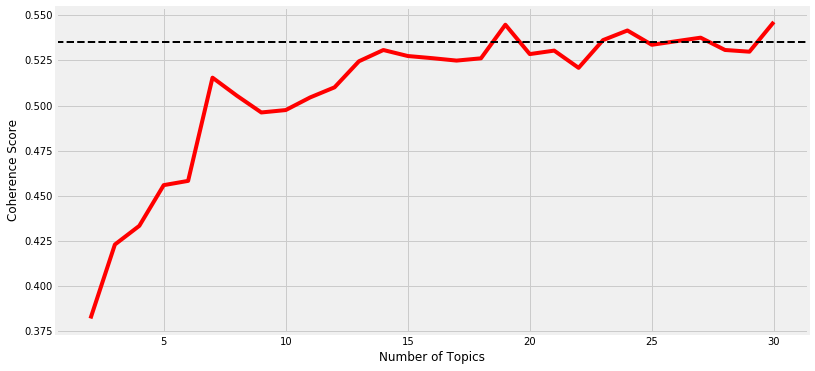

In [62]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

x_ax = range(2, 31, 1)
y_ax = coherence_scores
plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_ax, c='r')
plt.axhline(y=0.535, c='k', linestyle='--', linewidth=2)
plt.rcParams['figure.facecolor'] = 'white'
xl = plt.xlabel('Number of Topics')
yl = plt.ylabel('Coherence Score')

From Figure 6-7, it looks like the score starts increasing rapidly when the number of
topics is five and gradually starts plateauing at 19 or 20. We choose the optimal number
of topics as 20, based on our intuition

**We can retrieve the best model now:**

In [63]:
best_model_idx = coherence_df[coherence_df['Number of Topics'] == 20].index[0]
best_lda_model = lda_models[best_model_idx]
best_lda_model.num_topics

20

Let’s view all the 20 topics generated by our selected best model, similar to our
previous models

In [64]:
topics = [[(term, round(wt, 3)) 
               for term, wt in best_lda_model.show_topic(n, topn=20)] 
                   for n in range(0, best_lda_model.num_topics)]

for idx, topic in enumerate(topics):
    print('Topic #'+str(idx+1)+':')
    print([term for term, wt in topic])
    print()

Topic #1:
['control', 'adaptive', 'dynamic', 'controller', 'forward', 'feedback', 'nonlinear', 'change', 'desired', 'adaptation', 'rate', 'application', 'gain', 'linear', 'signal', 'trajectory', 'behavior', 'inverse', 'load', 'architecture']

Topic #2:
['word', 'recognition', 'speech', 'training', 'character', 'sequence', 'hmm', 'context', 'feature', 'frame', 'letter', 'speaker', 'mlp', 'speech_recognition', 'phoneme', 'state', 'digit', 'trained', 'vowel', 'experiment']

Topic #3:
['node', 'solution', 'constraint', 'tree', 'graph', 'code', 'energy', 'vector', 'optimization', 'bit', 'variable', 'path', 'cost', 'matrix', 'distance', 'match', 'temperature', 'assignment', 'binary', 'find']

Topic #4:
['unit', 'rule', 'activation', 'representation', 'sequence', 'recurrent', 'structure', 'connectionist', 'pattern', 'symbol', 'language', 'string', 'step', 'level', 'context', 'represent', 'processing', 'role', 'note', 'architecture']

Topic #5:
['search', 'feature', 'experiment', 'instance', '

A better way of visualizing the topics is to build a term-topic dataframe

Generated topics from our LDA topic model

In [65]:
topics_df = pd.DataFrame([[term for term, wt in topic] 
                              for topic in topics], 
                         columns = ['Term'+str(i) for i in range(1, 21)],
                         index=['Topic '+str(t) for t in range(1, best_lda_model.num_topics+1)]).T
topics_df

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20
Term1,control,word,node,unit,search,motion,component,prediction,circuit,equation,distribution,neuron,image,local,class,state,cell,training,signal,bound
Term2,adaptive,recognition,solution,rule,feature,direction,mixture,training,chip,noise,probability,state,object,structure,classification,action,neuron,layer,frequency,theorem
Term3,dynamic,speech,constraint,activation,experiment,visual,matrix,estimate,current,vector,prior,memory,feature,cluster,classifier,step,activity,unit,spike,size
Term4,controller,training,tree,representation,instance,position,variable,regression,neuron,rate,sample,dynamic,pixel,region,vector,policy,response,hidden_unit,response,class
Term5,forward,character,graph,sequence,table,map,vector,estimation,voltage,convergence,density,pattern,face,expert,kernel,reinforcement_learning,synaptic,net,channel,threshold
Term6,feedback,sequence,code,recurrent,query,target,gaussian,ensemble,analog,gradient,bayesian,phase,view,clustering,training,task,pattern,task,noise,approximation
Term7,nonlinear,hmm,energy,structure,user,location,source,test,bit,optimal,gaussian,attractor,surface,level,pattern,optimal,stimulus,pattern,filter,proof
Term8,change,context,vector,connectionist,test,field,linear,estimator,processor,eq,estimate,module,edge,part,feature,environment,cortical,trained,stimulus,complexity
Term9,desired,feature,optimization,pattern,concept,subject,em,selection,implementation,solution,log,capacity,visual,mapping,distance,goal,layer,architecture,temporal,theory
Term10,adaptation,frame,bit,symbol,domain,velocity,step,variance,computation,line,approximation,connection,scale,group,rbf,robot,firing,training_set,rate,polynomial


Another easy way to view the topics is to create a topic-term dataframe, whereby
each topic is represented in a row with the terms of the topic being represented as a
comma-separated string

In [66]:
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic])  
                              for topic in topics],
                         columns = ['Terms per Topic'],
                         index=['Topic'+str(t) for t in range(1, best_lda_model.num_topics+1)]
                         )
topics_df

C:\Users\Mido\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,Terms per Topic
Topic1,"control, adaptive, dynamic, controller, forward, feedback, nonlinear, change, desired, adaptation, rate, application, gain, linear, signal, trajectory, behavior, inverse, load, architecture"
Topic2,"word, recognition, speech, training, character, sequence, hmm, context, feature, frame, letter, speaker, mlp, speech_recognition, phoneme, state, digit, trained, vowel, experiment"
Topic3,"node, solution, constraint, tree, graph, code, energy, vector, optimization, bit, variable, path, cost, matrix, distance, match, temperature, assignment, binary, find"
Topic4,"unit, rule, activation, representation, sequence, recurrent, structure, connectionist, pattern, symbol, language, string, step, level, context, represent, processing, role, note, architecture"
Topic5,"search, feature, experiment, instance, table, query, user, test, concept, domain, random, application, hypothesis, block, target, accuracy, technique, task, machine, human"
Topic6,"motion, direction, visual, position, map, target, location, field, subject, velocity, movement, motor, human, hand, response, task, cue, spatial, sensory, arm"
Topic7,"component, mixture, matrix, variable, vector, gaussian, source, linear, em, step, pca, ica, em_algorithm, basis, hidden, coefficient, approximation, missing, nonlinear, principal_component"
Topic8,"prediction, training, estimate, regression, estimation, ensemble, test, estimator, selection, variance, time_series, variable, cross_validation, training_set, pruning, step, risk, nonlinear, predictor, bias"
Topic9,"circuit, chip, current, neuron, voltage, analog, bit, processor, implementation, computation, design, device, synapse, operation, array, digital, parallel, neural, hardware, transistor"
Topic10,"equation, noise, vector, rate, convergence, gradient, optimal, eq, solution, line, curve, linear, theory, constant, matrix, average, rule, gradient_descent, limit, minimum"


The dataframe depicted gives us an easy way to visualize and
understand the major themes in our corpus of research papers.

observed some very interesting themes around neural networks,
signal processing, dimension reduction, reinforcement learning, neural models in chips,
and image and visual recognition!

# Interpreting Topic Model Results

 given a corpus of documents (in the form of
features, e.g., Bag of Words) and a trained topic model, you can predict the distribution of
topics in each document (research paper in this case) with the following code.

We can now get the most dominant topic per research paper with some intelligent
sorting and indexing using the following code

In [67]:
tm_results = best_lda_model[bow_corpus]
corpus_topics = [sorted(topics, key=lambda record: -record[1])[0] for topics in tm_results]
corpus_topics[:5]

[(19, 0.29809670781893005),
 (8, 0.2944641916798316),
 (9, 0.27273315224421163),
 (11, 0.2211644591611479),
 (19, 0.4015970098538906)]

This provides a plethora of options that can be leveraged to extract useful insights
from our corpus of research papers

To enable this, we construct a master dataframe that
will hold the base statistics, which we use soon to depict different useful insights.

In [72]:
corpus_topic_df = pd.DataFrame()
corpus_topic_df['Document'] = range(0, len(papers))
corpus_topic_df['Dominant Topic'] = [item[0]+1 for item in corpus_topics]
corpus_topic_df['Contribution %'] = [round(item[1]*100, 2) for item in corpus_topics]
corpus_topic_df['Topic Desc'] = [topics_df.iloc[t[0]]['Terms per Topic'] for t in corpus_topics]
corpus_topic_df['Paper'] = papers

**Let’s now take a look at various ways we can transform these results and extract
meaningful insights from our research papers and their topics.**

# Dominant Topics Distribution Across Corpus

The first thing we can do is look at the overall distribution of each topic across the corpus
of research papers. Mainly we want to determine the total number of papers and the
total percentage of papers where each of the 20 topics was the most dominant

In [84]:
pd.set_option('display.max_colwidth', 200)
topic_stats_df = corpus_topic_df.groupby('Dominant Topic').agg({
                                                'Dominant Topic': {
                                                    'Doc Count': np.size,
                                                    '% Total Docs': np.size }
                                              })
topic_stats_df = topic_stats_df['Dominant Topic'].reset_index()
topic_stats_df['% Total Docs'] = topic_stats_df['% Total Docs'].apply(lambda row: round((row*100) / len(papers), 2))
topic_stats_df['Topic Desc'] = [topics_df.iloc[t]['Terms per Topic'] for t in range(len(topic_stats_df))]
topic_stats_df

SpecificationError: nested renamer is not supported

# Dominant Topics in Specific Research Papers

In [85]:
pd.set_option('display.max_colwidth', 200)
(corpus_topic_df[corpus_topic_df['Document']
                 .isin([681, 9, 392, 1622, 17, 
                        906, 996, 503, 13, 733])])

,Document,Dominant Topic,Contribution %,Topic Desc,Paper
9,9,19,42.50,"signal, frequency, spike, response, channel, noise, filter, stimulus, temporal, rate, correlation, phase, sound, amplitude, auditory, event, change, neural, threshold, detection","95 \nOPTIMAL NEURAL SPIKE CLASSIFICATION \nAmir F. Atiya(*) and Ja,nes M. Bower(**) \n(*) Dept. of Electrical Engineering \n(**) Division of Biology \nCalifornia Institute of Technology \nCa 91125..."
13,13,20,36.87,"bound, theorem, size, class, threshold, approximation, proof, complexity, theory, polynomial, linear, loss, defined, definition, constant, bounded, property, assume, define, condition",137 \nOn the \nPower of Neural Networks for \nSolving Hard Problems \nJehoshua Bruck \nJoseph W. Goodman \nInformation Systems Laboratory \nDepartment of Electrical Engineering \nStanford Universi...
17,17,3,23.10,"node, solution, constraint, tree, graph, code, energy, vector, optimization, bit, variable, path, cost, matrix, distance, match, temperature, assignment, binary, find","174 \nA Neural Network C1A-sifier Based on Coding Theory \nTzi-Dar Chiueh and Rodney Goodman \nCalifornia Institute of Technology, Pasadena, California 91125 \nABSTRACT\nThe new neural network cla..."
392,392,4,48.99,"unit, rule, activation, representation, sequence, recurrent, structure, connectionist, pattern, symbol, language, string, step, level, context, represent, processing, role, note, architecture",Connectionist Music Composition Based on \nMelodic and Stylistic Constraints \nMichael C. Mozer \nDepartment of Computer Science \nand Institute of Cognitive Science \nUniversity of Colorado \nBou...
503,503,6,53.73,"motion, direction, visual, position, map, target, location, field, subject, velocity, movement, motor, human, hand, response, task, cue, spatial, sensory, arm",A Cortico-Cerebellar Model that Learns to \nGenerate Distributed Motor Commands to \nControl a Kinematic Arm \nN.E. Bertbier S.P. Singh A.CI. Barto \nDepartment of Computer Science \nUniversity of...
681,681,5,53.35,"search, feature, experiment, instance, table, query, user, test, concept, domain, random, application, hypothesis, block, target, accuracy, technique, task, machine, human","A Knowledge-Based Model of Geometry Learning \nGeoffrey Towell \nSiemens Corporate Research \n755 College Road East \nPrinceton, NJ 08540 \ntoweli @ learning. siemens. com \nRichard Lehrer \nEduca..."
733,733,8,33.51,"prediction, training, estimate, regression, estimation, ensemble, test, estimator, selection, variance, time_series, variable, cross_validation, training_set, pruning, step, risk, nonlinear, predi...",Optimal Brain Surgeon: \nExtensions and performance comparisons \nBabak Hassibi* \nDavid G. Stork \nGregory Wolff \nTakahiro Watanabe \nRicoh California Research Center \n2882 Sand Hill Road Suite...
906,906,4,28.87,"unit, rule, activation, representation, sequence, recurrent, structure, connectionist, pattern, symbol, language, string, step, level, context, represent, processing, role, note, architecture","Extracting Rules from Artificial Neural Networks \nwith Distributed Representations \nSebastian Thrun \nUniversity of Bonn \nDepartment of Computer Science III \nR6merstr. 164, D-53117 Bonn, Germa..."
996,996,6,56.38,"motion, direction, visual, position, map, target, location, field, subject, velocity, movement, motor, human, hand, response, task, cue, spatial, sensory, arm",A Dynamical Model of Context Dependencies for the \nVestibulo-Ocular Reflex \nO!ivier J.M.D. Coenen* \nTerrence J. Sejnowskit \nComputational Neurobiology Laboratory \nHoward Hughes Medical Instit...
1622,1622,15,47.69,"class, classification, classifier, vector, kernel, training, pattern, feature, distance, rbf, machine, test, linear, training_set, nearest_neighbor, margin, transformation, sample, support_vector,...","Model Selection for Support Vector Machines \nOlivier Chapelle*,t, Vladimir Vapnik* \n* AT&T Research Labs, Red Bank, NJ \nt LIP6, Paris, France \n{ chape

# Relevant Research Papers per Topic based on Dominance

In [86]:
corpus_topic_df.groupby('Dominant Topic').apply(lambda topic_set: (topic_set.sort_values(by=['Contribution %'], 
                                                                                         ascending=False)
                                                                             .iloc[0]))

,Document,Dominant Topic,Contribution %,Topic Desc,Paper
Dominant Topic,,,,,
1,971,1,67.81,"control, adaptive, dynamic, controller, forward, feedback, nonlinear, change, desired, adaptation, rate, application, gain, linear, signal, trajectory, behavior, inverse, load, architecture","An Integrated Architecture of Adaptive Neural Network \nControl for Dynamic Systems \nLiu Ke '2 Robert L. Tokaf Brian D.McVey z \nCenter for Nonlinear Studies, 2Applied Theoretical Physics Divis..."
2,660,2,71.35,"word, recognition, speech, training, character, sequence, hmm, context, feature, frame, letter, speaker, mlp, speech_recognition, phoneme, state, digit, trained, vowel, experiment","Connected Letter Recognition with a \nMulti-State Time Delay Neural Network \nHermann Hild and Alex Waibel \nSchool of Computer Science \nCarnegie Mellon University \nPittsburgh, PA 15213-3891, US..."
3,1072,3,66.79,"node, solution, constraint, tree, graph, code, energy, vector, optimization, bit, variable, path, cost, matrix, distance, match, temperature, assignment, binary, find","Softassign versus Softmax: Benchmarks \nin Combinatorial Optimization \nSteven Gold \nDepartment of Computer Science \nYale University \nNew Haven, CT 06520-8285 \nAnand Rangarajan \nDept. of Diag..."
4,678,4,69.11,"unit, rule, activation, representation, sequence, recurrent, structure, connectionist, pattern, symbol, language, string, step, level, context, represent, processing, role, note, architecture",A Connectionist Symbol Manipulator \nThat Discovers the Structure of \nContext-Free Languages \nMichael C. Mozer and Sreerupa Das \nDepartment of Computer Science & \nInstitute of Cognitive Scienc...
5,1418,5,59.98,"search, feature, experiment, instance, table, query, user, test, concept, domain, random, application, hypothesis, block, target, accuracy, technique, task, machine, human","Learning to Schedule Straight-Line Code \nEliot Moss, Paul Utgoff, John Cavazos \nDoina Precup, Darko Stefanovi(: \nDept. of Comp. Sci., Univ. of Mass. \nAmherst, MA 01003 \nCarla Brodley, David S..."
6,504,6,69.99,"motion, direction, visual, position, map, target, location, field, subject, velocity, movement, motor, human, hand, response, task, cue, spatial, sensory, arm",A Computational Mechanism To Account For \nAveraged Modified Hand Trajectories \nEalan A. Henis*and Tamar Flash \nDepartment of Applied Mathematics and Computer Science \nThe Weizmann Institute of...
7,1510,7,57.70,"component, mixture, matrix, variable, vector, gaussian, source, linear, em, step, pca, ica, em_algorithm, basis, hidden, coefficient, approximation, missing, nonlinear, principal_component","Unsupervised Classification with \nNon-Gaussian Mixture Models using ICA \nTe-Won Lee, Michael S. Lewicki and Terrence Sejnowski \nHoward Hughes Medical Institute \nComputational Neurobiology Labo..."
8,512,8,57.37,"prediction, training, estimate, regression, estimation, ensemble, test, estimator, selection, variance, time_series, variable, cross_validation, training_set, pruning, step, risk, nonlinear, predi...",Principled Architecture Selection \nfor Neural Networks: \nApplication to Corporate Bond Rating Prediction \nJohn Moody \nDepartment of Computer Science \nYale University \nP.O. Box 2158 Yale Stat...
9,945,9,71.47,"circuit, chip, current, neuron, voltage, analog, bit, processor, implementation, computation, design, device, synapse, operation, array, digital, parallel, neural, hardware, transistor","Single Transistor Learning Synapses \nPaul Hasler, Chris Diorio, Bradley A. Minch, Carver Mead \nCalifornia Institute of Technology \nPasadena, CA 91125 \n(SlS) 95- 2S12 \npaul@hobiecat.pcmp.calt..."


# Predicting Topics for New Research Papers

Even though topic models are unsupervised models, we can estimate or predict
potential topics for new documents based on what it has learned previously on the
so-called “training” corpus.

For testing our model, I have manually downloaded some
recent papers from the NIPS 16 conference proceedings. Testing our model on these
papers is going to be an interesting exercise.

In [88]:
import glob
# papers manually downloaded from NIPS 16
#https://papers.nips.cc/paper/2016

new_paper_files = glob.glob('nips16*.txt')
new_papers = []
for fn in new_paper_files:
    with open(fn, encoding='utf-8', errors='ignore', mode='r+') as f:
        data = f.read()
        new_papers.append(data)
              
print('Total New Papers:', len(new_papers))

Total New Papers: 0


In [89]:
def text_preprocessing_pipeline(documents, normalizer_fn, bigram_model):
    norm_docs = normalizer_fn(documents)
    norm_docs_bigrams = bigram_model[norm_docs]
    return norm_docs_bigrams

def bow_features_pipeline(tokenized_docs, dictionary):
    paper_bow_features = [dictionary.doc2bow(text) 
                              for text in tokenized_docs]
    return paper_bow_features

norm_new_papers = text_preprocessing_pipeline(documents=new_papers, normalizer_fn=normalize_corpus, 
                                              bigram_model=bigram_model)
norm_bow_features = bow_features_pipeline(tokenized_docs=norm_new_papers, dictionary=dictionary)